# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn
import plotly.io as pio
import plotly.graph_objs as go

from pytorch_forecasting import Baseline, TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-16 21:32:06.123942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:32:06.170563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:32:06.171277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 21:32:06.872049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Define Constants, Functions

In [5]:
model_dir = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=8-step=360882.ckpt


In [6]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*7   # <------------------------------------------------- DOUBLE CHECK IT MATCHES WITH MODEL
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [7]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

## Prepare dataloaders for splits

In [35]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)
train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


In [36]:
## TEMP SUBSET VAL FOR DEV SPEED

# # Setup dataset
# train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
# test_df_subset = test_df.loc[test_df['site_id'].isin(['AU-Stp', 'FR-Bil']), ].copy()
# train_df, val_df, test_df_subset = subset_data(train_df, val_df, test_df_subset, SUBSET_LEN)
# train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df_subset, ENCODER_LEN)

## Select which split to evaluate

In [37]:
eval_split = 'test'

if eval_split == 'val':
    dataloader = validation
    split_df = val_df.copy()
elif eval_split == 'test':
    dataloader = test
    split_df = test_df.copy()

## Get raw predictions

In [38]:
# Get raw preds (too big to save to disk)
raw_preds = best_tft.predict(dataloader, mode="raw", return_x=False)
preds_p50 = raw_preds['prediction'][:, :, 3].reshape(-1)
preds_p10 = raw_preds['prediction'][:, :, 1].reshape(-1)
preds_p90 = raw_preds['prediction'][:, :, 5].reshape(-1)

# Load actuals and mask, which were saved out in performance_metrics_by_site (should be run first for each model)
try:
    print("Loading actuals and mask from previous eval script")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "rb") as fin:
        actuals = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "rb") as fin:
        mask = pickle.load(fin)
except:
    print("Unable to lod mask, actuals. Running now...")
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list).reshape(-1)
    mask = torch.logical_not(torch.cat(mask_list))

Loading actuals and mask from previous eval script


In [39]:
# Create a dataframe for the decoded index of dataloader
dec_ind_df = pd.DataFrame(dataloader.decoded_index)
dec_ind_df = pd.merge(dec_ind_df, split_df[['site_id', 'IGBP']].drop_duplicates(), how='left', on='site_id')

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction,IGBP
0,AU-Stp,350640,350808,350808,GRA
1,AU-Stp,350641,350809,350809,GRA
2,AU-Stp,350642,350810,350810,GRA


In [47]:
## Add IGBP name
newnames = {
    'ENF': 'Evergreen Needleleaf Forests',
    'EBF': 'Evergreen Broadleaf Forests',
    'DNF': 'Deciduous Needleleaf Forests', 
    'DBF': 'Deciduous Broadleaf Forests',
    'MF' : 'Mixed Forests',
    'CSH': 'Closed Shrublands',
    'OSH': 'Open Shrublands',
    'WSA': 'Woody Savannas',
    'SAV': 'Savannas',
    'GRA': 'Grasslands',
    'CRO': 'Croplands',
    'CVM': 'Cropland/<br>Natural Vegetation Mosaics',
    'WET': 'Permanent Wetlands',
    'URB': 'Urban and Built-up Lands',
    'SNO': 'Snow and Ice',
    'BSV': 'Barren',
    'WAT': 'Water Bodies',}
dec_ind_df['IGBP_name'] = dec_ind_df['IGBP'].map(newnames)
dec_ind_df.head(3)

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction,IGBP,IGBP_name
0,AU-Stp,350640,350808,350808,GRA,Grasslands
1,AU-Stp,350641,350809,350809,GRA,Grasslands
2,AU-Stp,350642,350810,350810,GRA,Grasslands


## Get overall attention curve and feature importances

In [40]:
# Get avg feature imps, attn
enc_fi_avg = list(torch.mean(torch.mean(raw_preds['encoder_variables'], dim=0).squeeze(), dim=0).numpy())
dec_fi_avg = list(torch.mean(raw_preds['decoder_variables'], dim=0).squeeze().numpy())
enc_attn_avg = torch.mean(raw_preds['encoder_attention'], dim=0).squeeze()

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

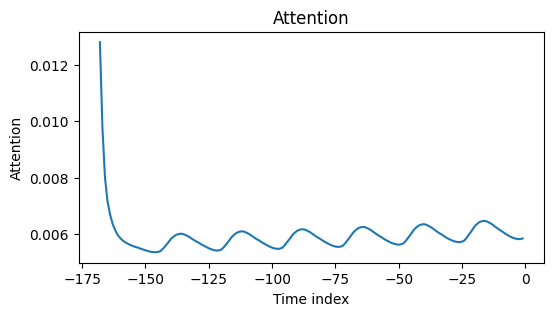

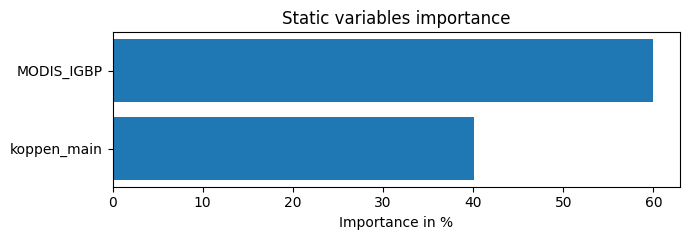

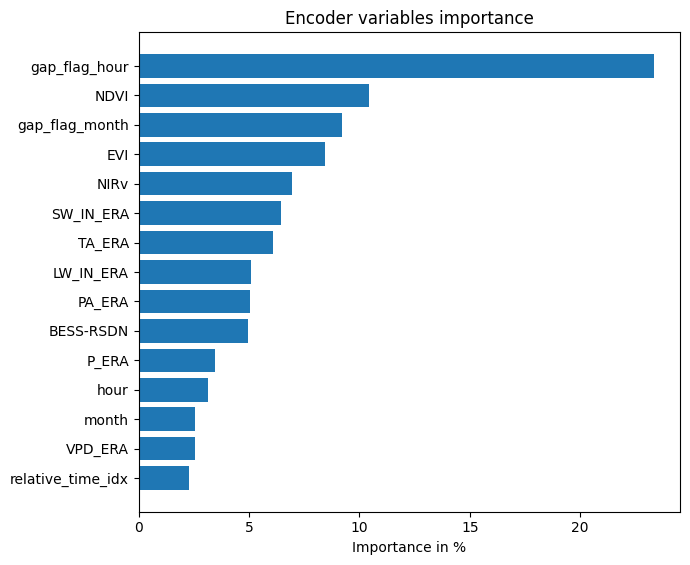

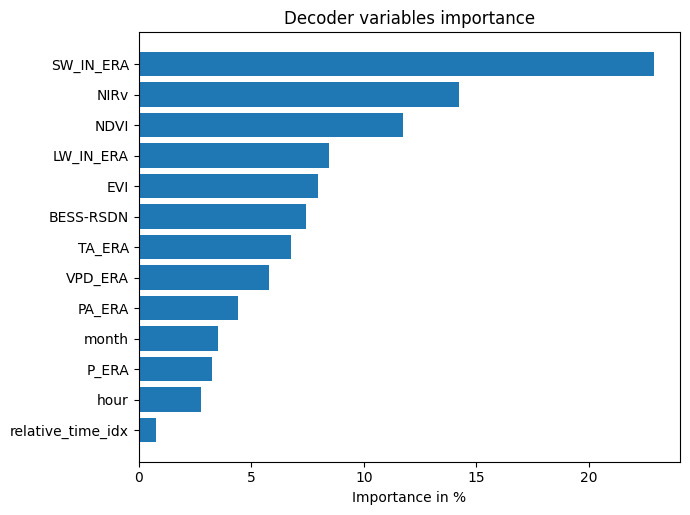

In [13]:
interpretation_sum = best_tft.interpret_output(raw_preds, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

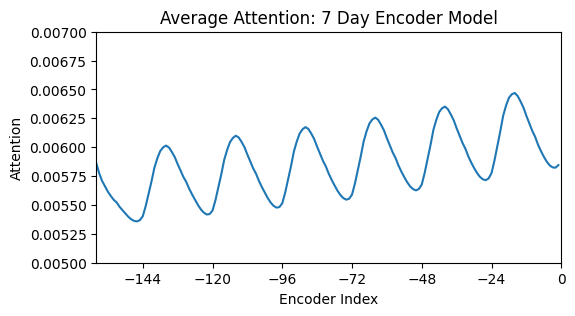

In [88]:
# Create a figure and axis object
fig, ax = plt.subplots()
ax.plot(range(-ENCODER_LEN, 0), enc_attn_avg)
ax.set_xlim([-ENCODER_LEN+8, 0])
ax.set_ylim([0.0050, 0.007])
ax.set_xticks(np.arange(0, -ENCODER_LEN, -24))
ax.set_ylabel('Attention')
ax.set_xlabel('Encoder Index')
plt.title('Average Attention: 7 Day Encoder Model')
plt.show()

## Get feature importances by site

In [14]:
# Align values with features
known_cat=["month", "hour"]
known_real=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN']
unknown_cat=["gap_flag_month", "gap_flag_hour"]
enc_features = known_cat + unknown_cat + known_real + ['relative_time_idx'] 
dec_features = known_cat + known_real + ['relative_time_idx'] 

In [15]:
# Create dataframe for site-encoder-feature-imps, site-decoder-feature-imps
site_enc_fi_df = pd.DataFrame(columns= ['site_id'] + enc_features)
site_dec_fi_df = pd.DataFrame(columns= ['site_id'] + dec_features)

# Add average attn to dfs
site_enc_fi_df.loc[len(site_enc_fi_df)] = ['Average'] + enc_fi_avg
site_dec_fi_df.loc[len(site_dec_fi_df)] = ['Average'] + dec_fi_avg

# Loop through sites, getting enc and dec feature importances
for site in tqdm(dec_ind_df['site_id'].unique()):
    # Get site feature imps
    site_inds = dec_ind_df.loc[dec_ind_df['site_id']==site, ].index
    site_enc_fi_means = list(torch.mean(torch.mean(raw_preds['encoder_variables'][site_inds], dim=0).squeeze(), dim=0).numpy())
    site_dec_fi_means = list(torch.mean(raw_preds['decoder_variables'][site_inds], dim=0).squeeze().numpy())

    # Append to df
    site_enc_fi_df.loc[len(site_enc_fi_df)] = [site] + site_enc_fi_means
    site_dec_fi_df.loc[len(site_dec_fi_df)] = [site] + site_dec_fi_means

    
# Save site-fi dfs
site_enc_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_site_encoder_feature_imps.csv'), index=False)
site_dec_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_site_decoder_feature_imps.csv'), index=False)

100%|██████████| 25/25 [00:03<00:00,  7.91it/s]


## Get feature importances by IGBP

In [16]:
# Create dataframe for site-encoder-feature-imps, site-decoder-feature-imps
igbp_enc_fi_df = pd.DataFrame(columns= ['IGBP'] + enc_features)
igbp_dec_fi_df = pd.DataFrame(columns= ['IGBP'] + dec_features)

# Add average attn to dfs
igbp_enc_fi_df.loc[len(igbp_enc_fi_df)] = ['Average'] + enc_fi_avg
igbp_dec_fi_df.loc[len(igbp_dec_fi_df)] = ['Average'] + dec_fi_avg

# Loop through IGBPS, getting enc and dec feature importances
for igbp in tqdm(dec_ind_df['IGBP'].unique()):
    # Get site feature imps
    igbp_inds = dec_ind_df.loc[dec_ind_df['IGBP']==igbp, ].index
    igbp_enc_fi_means = list(torch.mean(torch.mean(raw_preds['encoder_variables'][igbp_inds], dim=0).squeeze(), dim=0).numpy())
    igbp_dec_fi_means = list(torch.mean(raw_preds['decoder_variables'][igbp_inds], dim=0).squeeze().numpy())

    # Append to df
    igbp_enc_fi_df.loc[len(igbp_enc_fi_df)] = [site] + igbp_enc_fi_means
    igbp_dec_fi_df.loc[len(igbp_dec_fi_df)] = [site] + igbp_dec_fi_means
    
    
# Save site-fi dfs
igbp_enc_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_igbp_encoder_feature_imps.csv'), index=False)
igbp_dec_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_igbp_decoder_feature_imps.csv'), index=False)

100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


## Investigate tables

In [17]:
print("Display encoder feature importance df by site")
styled_enc_df = site_enc_fi_df.style.background_gradient(cmap='Greens')
display(styled_enc_df)

print("\nDisplay decoder feature importance df by site")
styled_dec_df = site_dec_fi_df.style.background_gradient(cmap='Greens')
display(styled_dec_df)

Display encoder feature importance df by site


,site_id,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.025616,0.031383,0.092096,0.233591,0.060634,0.064289,0.051071,0.025364,0.034706,0.050606,0.084609,0.104405,0.069611,0.049449,0.022570
1,AU-Stp,0.017451,0.020875,0.041772,0.182596,0.045912,0.024912,0.103607,0.046431,0.023866,0.044584,0.152566,0.135664,0.051150,0.065877,0.042737
2,AU-Whr,0.022046,0.030760,0.079175,0.297848,0.053637,0.048344,0.058201,0.022780,0.014714,0.060640,0.035122,0.162388,0.049108,0.031872,0.033365
3,CA-Oas,0.018656,0.043764,0.123801,0.270780,0.031018,0.066191,0.052056,0.019502,0.030330,0.035089,0.102848,0.071896,0.078818,0.042303,0.012948
4,CH-Dav,0.025010,0.033506,0.138343,0.133956,0.034880,0.090011,0.047257,0.025978,0.155314,0.019840,0.090526,0.041485,0.074764,0.077032,0.012096
5,CZ-Lnz,0.022206,0.041864,0.108893,0.305314,0.037350,0.061710,0.055866,0.027205,0.014406,0.029954,0.017686,0.139989,0.081859,0.034470,0.021230
6,CZ-wet,0.029715,0.029310,0.108080,0.246897,0.074829,0.089511,0.027506,0.017891,0.014420,0.055454,0.056364,0.103212,0.090518,0.045535,0.010758
7,DE-Gri,0.026405,0.032609,0.090201,0.224340,0.079304,0.097829,0.030181,0.022042,0.016146,0.060688,0.056323,0.119967,0.086352,0.042486,0.015127
8,DE-Lnf,0.025391,0.030999,0.118054,0.314389,0.051330,0.088798,0.029323,0.017956,0.014914,0.038089,0.028219,0.095985,0.084635,0.048557,0.013362
9,DE-Tha,0.022446,0.029912,0.115514,0.309937,0.050550,0.083225,0.033364,0.020485,0.014874,0.039855,0.021017,0.086153,0.092766,0.059233,0.020667



Display decoder feature importance df by site


,site_id,month,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.035093,0.027620,0.067569,0.228935,0.084574,0.057954,0.032736,0.043980,0.079661,0.117427,0.142192,0.074433,0.007826
1,AU-Stp,0.037302,0.030732,0.081979,0.264608,0.045200,0.063342,0.027885,0.038959,0.073444,0.184151,0.100061,0.044777,0.007560
2,AU-Whr,0.038633,0.033496,0.089484,0.367609,0.071031,0.053432,0.024791,0.050341,0.076325,0.135751,0.027023,0.019943,0.012140
3,CA-Oas,0.026959,0.030261,0.060131,0.147802,0.080633,0.055418,0.022847,0.038155,0.077847,0.088821,0.237952,0.125109,0.008065
4,CH-Dav,0.033070,0.024094,0.058372,0.179619,0.086860,0.054959,0.059783,0.030232,0.074256,0.138093,0.161758,0.090149,0.008755
5,CZ-Lnz,0.032709,0.030340,0.069973,0.238005,0.084946,0.063844,0.020604,0.052824,0.088075,0.090481,0.110527,0.109545,0.008127
6,CZ-wet,0.036097,0.024139,0.063749,0.238293,0.097414,0.059980,0.034072,0.068110,0.084148,0.086827,0.126031,0.073869,0.007268
7,DE-Gri,0.034970,0.029086,0.079924,0.299308,0.106331,0.058999,0.029608,0.065387,0.072956,0.072200,0.077872,0.064170,0.009190
8,DE-Lnf,0.035876,0.024557,0.062631,0.236727,0.097646,0.060960,0.034351,0.056864,0.087469,0.088215,0.123105,0.084654,0.006945
9,DE-Tha,0.036695,0.022965,0.062329,0.255769,0.094651,0.061011,0.031751,0.047816,0.096148,0.113832,0.092377,0.077403,0.007254


In [18]:
print("Display encoder feature importance df by site")
styled_igbp_enc_df = igbp_enc_fi_df.style.background_gradient(cmap='Greens')
display(styled_igbp_enc_df)

print("\nDisplay decoder feature importance df by site")
styled_igbp_dec_df = igbp_dec_fi_df.style.background_gradient(cmap='Greens')
display(styled_igbp_dec_df)

Display encoder feature importance df by site


,IGBP,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.025616,0.031383,0.092096,0.233591,0.060634,0.064289,0.051071,0.025364,0.034706,0.050606,0.084609,0.104405,0.069611,0.049449,0.022570
1,US-Whs,0.026167,0.027082,0.080059,0.204424,0.062052,0.056115,0.051048,0.028304,0.046343,0.048808,0.130152,0.096486,0.065266,0.052260,0.025433
2,US-Whs,0.022046,0.030760,0.079175,0.297848,0.053637,0.048344,0.058201,0.022780,0.014714,0.060640,0.035122,0.162388,0.049108,0.031872,0.033365
3,US-Whs,0.022818,0.038808,0.114330,0.299194,0.040499,0.074064,0.047969,0.022478,0.017235,0.034705,0.039217,0.113390,0.077406,0.041609,0.016279
4,US-Whs,0.025412,0.032703,0.112959,0.222733,0.076068,0.076716,0.041856,0.021381,0.046712,0.057737,0.057393,0.088705,0.075411,0.048165,0.016048
5,US-Whs,0.029715,0.029310,0.108080,0.246897,0.074829,0.089511,0.027506,0.017891,0.014420,0.055454,0.056364,0.103212,0.090518,0.045535,0.010758
6,US-Whs,0.036486,0.025538,0.067531,0.156518,0.048163,0.025869,0.063619,0.017971,0.054294,0.064762,0.229182,0.078510,0.069049,0.048848,0.013660
7,US-Whs,0.014752,0.026901,0.066319,0.303346,0.035090,0.057923,0.060817,0.042282,0.008010,0.034866,0.069442,0.089291,0.070352,0.063797,0.056812
8,US-Whs,0.024848,0.032204,0.089466,0.240451,0.072588,0.082094,0.044377,0.030259,0.015381,0.052763,0.024846,0.123141,0.078422,0.066031,0.023129
9,US-Whs,0.025477,0.041441,0.067149,0.272369,0.039682,0.053636,0.084418,0.030432,0.007688,0.037665,0.044719,0.182079,0.042358,0.042164,0.028723



Display decoder feature importance df by site


,IGBP,month,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.035093,0.027620,0.067569,0.228935,0.084574,0.057954,0.032736,0.043980,0.079661,0.117427,0.142192,0.074433,0.007826
1,US-Whs,0.034366,0.029558,0.069543,0.204247,0.075079,0.057006,0.034645,0.041773,0.077629,0.122681,0.177533,0.068419,0.007522
2,US-Whs,0.038633,0.033496,0.089484,0.367609,0.071031,0.053432,0.024791,0.050341,0.076325,0.135751,0.027023,0.019943,0.012140
3,US-Whs,0.032224,0.028830,0.066501,0.211233,0.088772,0.060754,0.025899,0.051518,0.086624,0.088085,0.146923,0.104940,0.007698
4,US-Whs,0.033671,0.026654,0.063585,0.236364,0.093058,0.056419,0.039804,0.044314,0.081562,0.106788,0.132872,0.076640,0.008269
5,US-Whs,0.036097,0.024139,0.063749,0.238293,0.097414,0.059980,0.034072,0.068110,0.084148,0.086827,0.126031,0.073869,0.007268
6,US-Whs,0.034892,0.031712,0.065320,0.178570,0.063936,0.055634,0.030521,0.026209,0.072288,0.183510,0.193766,0.056825,0.006816
7,US-Whs,0.040833,0.025145,0.060526,0.173302,0.076229,0.058909,0.021965,0.037831,0.074380,0.129169,0.194254,0.100711,0.006745
8,US-Whs,0.037648,0.024819,0.093435,0.334693,0.093305,0.059284,0.029518,0.038988,0.077984,0.116666,0.036995,0.048064,0.008601
9,US-Whs,0.037775,0.023889,0.064445,0.266907,0.095053,0.064608,0.022763,0.049395,0.081984,0.112527,0.090319,0.083006,0.007329


## Get attention curve by site

In [41]:
 def plot_attention_only(attention: torch.Tensor, group: str) -> plt.Figure:
    fig, ax = plt.subplots()
    attention = attention.detach().cpu()
    attention = attention / attention.sum(-1).unsqueeze(-1)
    ax.plot(
        np.arange(-ENCODER_LEN, attention.size(0) - ENCODER_LEN), attention
    )
    ax.set_xlabel("Time index")
    ax.set_ylabel(f"Attention")
    ax.set_title(f"Attention for {group}")
    plt.close(fig)
    return fig

In [42]:
# Create the directory for the plots if it doesn't already exist
plot_dir_site = os.path.join(exp_model_dir, 'site_attention_plots')
plot_dir_igbp = os.path.join(exp_model_dir, 'igbp_attention_plots')
if not os.path.exists(plot_dir_site):
    print("Creating attention plot directory for site attn")
    os.makedirs(plot_dir_site)
    
if not os.path.exists(plot_dir_igbp):
    print("Creating attention plot directory for IGBP attn")
    os.makedirs(plot_dir_igbp)

In [21]:
# Loop through sites, getting enc and dec feature importances
for site in tqdm(dec_ind_df['site_id'].unique()):
    # Get site feature imps
    site_inds = dec_ind_df.loc[dec_ind_df['site_id']==site, ].index
    
    # Get attention for those inds
    site_enc_attn = torch.mean(raw_preds['encoder_attention'][site_inds], dim=0).squeeze().detach().cpu()
    attn_plot = plot_attention_only(site_enc_attn, site)
    
    # Save plot
    attn_plot.savefig(os.path.join(plot_dir_site, f'attention_{site}.png'))

100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


## Get attention curve by IGBP

In [43]:
# Loop through sites, getting enc and dec feature importances
try:
    with open(os.path.join(plot_dir_igbp, f'{eval_split}_attention_igb.json'), 'rb') as f:
        igbb_attn_dict = pickle.load(f)
except:
    print("Failed to load, writing now")
    igbb_attn_dict = {}
    igbb_attn_dict['Average'] = enc_attn_avg
    for igbp in tqdm(dec_ind_df['IGBP_name'].unique()):
        # Get site feature imps
        igbp_inds = dec_ind_df.loc[dec_ind_df['IGBP_name']==igbp, ].index

        # Get attention for those inds
        igbp_enc_attn = torch.mean(raw_preds['encoder_attention'][igbp_inds], dim=0).squeeze().detach().cpu()
        igbb_attn_dict[igbp] = igbp_enc_attn

        # Plot and save
        attn_plot = plot_attention_only(igbp_enc_attn, igbp)
        #attn_plot.savefig(os.path.join(plot_dir_igbp, f'attention_{igbp}.png'))

    # Save igbb_attn_dict
    with open(os.path.join(plot_dir_igbp, f'{eval_split}_attention_igbp.json'), 'wb') as f:
        pickle.dump(igbb_attn_dict, f)

Failed to load, writing now


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


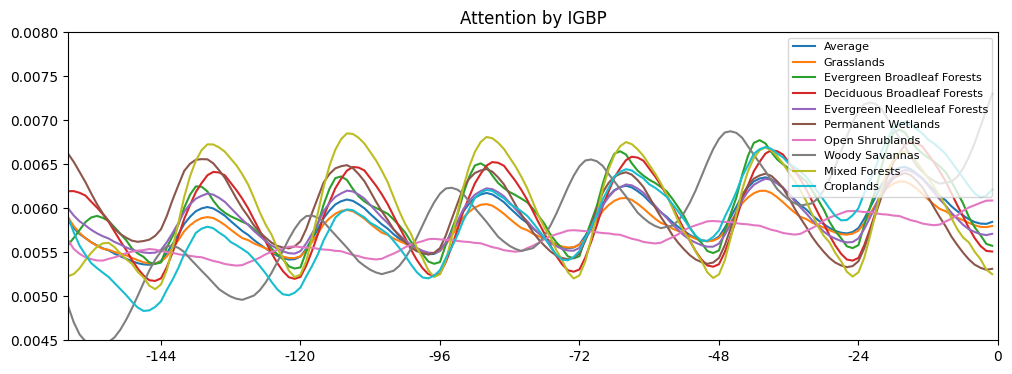

In [49]:
# Plot IGBP attn curves together
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(-ENCODER_LEN, 0)
for group, values in igbb_attn_dict.items():
    ax.plot(range(-ENCODER_LEN, 0), values, label=group)
ax.legend(loc='upper right', prop={'size': 8})
ax.set_xlim([-ENCODER_LEN+8, 0])
ax.set_ylim([0.0045, 0.008])
ax.set_xticks(np.arange(0, -ENCODER_LEN, -24))
ax.set_xticklabels([str(x) for x in np.arange(0, -ENCODER_LEN, -24)])
plt.title('Attention by IGBP')
plt.show()

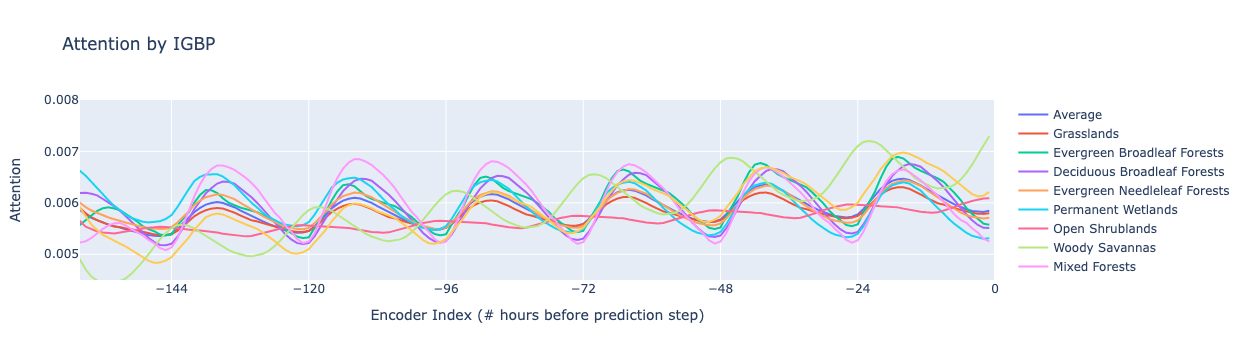

In [50]:
## CREATE PLOTLY FOR WEBSITE
# create a trace for each group
traces = []
for group, values in igbb_attn_dict.items():
    trace = go.Scatter(
        x=list(range(-ENCODER_LEN, 0)),
        y=values,
        mode='lines',
        name=group
    )
    traces.append(trace)

# set layout properties
layout = go.Layout(
    title='Attention by IGBP',
    xaxis=dict(
        title='Encoder Index (# hours before prediction step)',
        tickmode='array',
        tickvals=list(range(0, -ENCODER_LEN-1, -24)),
        range=[-ENCODER_LEN+8, 0]
    ),
    yaxis=dict(
        title='Attention',
        range=[0.0045, 0.008]
    )
)

# create a figure object
fig = go.Figure(data=traces, layout=layout)
fig.show()


# serialize the figure as JSON
fig_json = fig.to_json()
iframe = '<iframe srcdoc="{0}" style="width:100%; height:500px; border:none"></iframe>'.format(fig_json)

# create a HTML file with the embedded plotly chart
with open(os.path.join(plot_dir_igbp, f'{eval_split}_attention_igbp.html'), 'w') as f:
    f.write('<html><head><script src="https://cdn.plot.ly/plotly-latest.min.js"></script></head><body>')
    f.write('<div id="plot"></div>')
    f.write('<script>Plotly.newPlot("plot", {0});</script>'.format(fig_json))
    f.write('</body></html>')

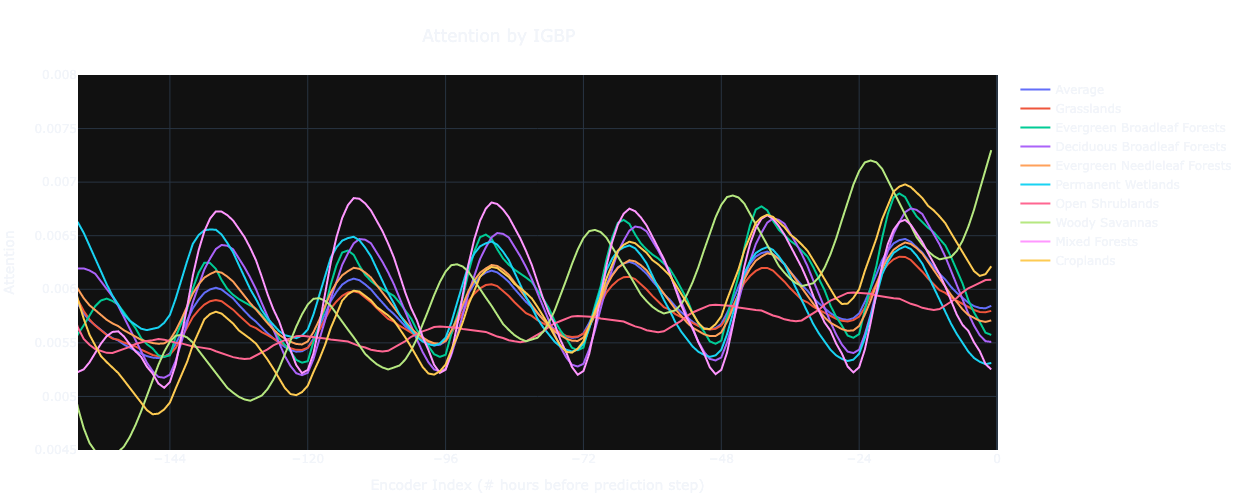

In [58]:
import plotly.subplots as sp
import plotly.graph_objs as go

# create a 1x1 grid of subplots
fig = sp.make_subplots(rows=1, cols=1)

# create a trace for each group
for group, values in igbb_attn_dict.items():
    trace = go.Scatter(
        x=list(range(-ENCODER_LEN, 0)),
        y=values,
        mode='lines',
        name=group
    )
    # add the trace to the subplot
    fig.add_trace(trace, row=1, col=1)

# set layout properties
fig.update_layout(title={'text': "Attention by IGBP", 'y':0.94,'x':0.4},
                  margin={"r":10,"t":75,"l":10,"b":50},
                  height=500, width=800,
                  hovermode="x unified",
                  hoverlabel={ 'bgcolor':"#333"},
                  template='plotly_dark')
fig.update_xaxes(title_text="Encoder Index (# hours before prediction step)",
                 tickmode='array',
                 tickvals=list(range(0, -ENCODER_LEN-1, -24)),
                 range=[-ENCODER_LEN+8, 0],
                 row=1, col=1)
fig.update_yaxes(title_text="Attention",
                 range=[0.0045, 0.008],
                 row=1, col=1)
fig.update_yaxes(title_text="Average Attention",
                 showgrid=False,
                 secondary_y=True,
                 row=1, col=1)


# For Dark background
fig.update_layout(paper_bgcolor="rgba(0,0,0,0)")

# show the figure
fig.show()


# serialize the figure as JSON
fig_json = fig.to_json()
iframe = '<iframe srcdoc="{0}" style="width:100%; height:500px; border:none"></iframe>'.format(fig_json)

# create a HTML file with the embedded plotly chart
with open(os.path.join(plot_dir_igbp, f'{eval_split}_attention_igbp_v2.html'), 'w') as f:
    f.write('<html><head><script src="https://cdn.plot.ly/plotly-latest.min.js"></script></head><body>')
    f.write('<div id="plot"></div>')
    f.write('<script>Plotly.newPlot("plot", {0});</script>'.format(fig_json))
    f.write('</body></html>')

### Get plot with 3 lines: Average attn, top igbp attn, bottom site attn (need to manually plug in top and bottom site)

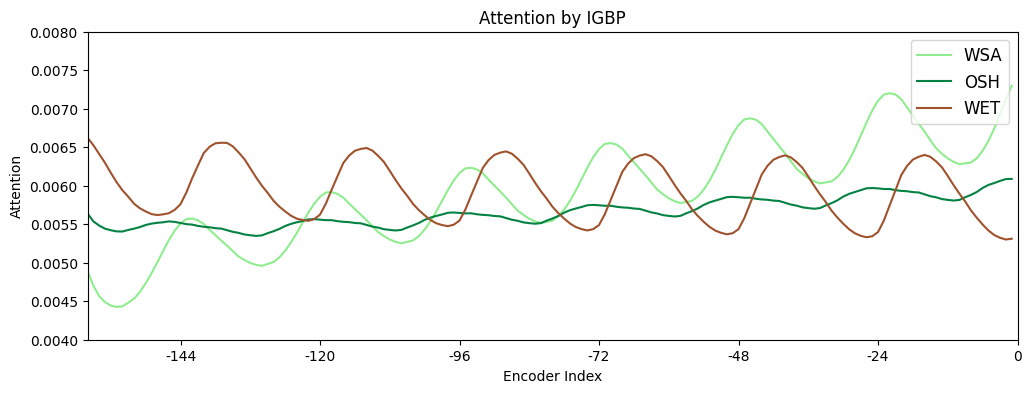

In [69]:
# Manually fill in the most diff attn curves
igbp_list = ['WSA', 'OSH', 'WET']
colors = ['#8FED8F', '#048243', '#A0522D']
igbb_attn_dict_subset = {key: igbb_attn_dict[key] for key in igbp_list if key in igbb_attn_dict}

# Plot IGBP attn curves together
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(-ENCODER_LEN, 0)
i=0
for group, values in igbb_attn_dict_subset.items():
    ax.plot(range(-ENCODER_LEN, 0), values, label=group, color=colors[i])
    i+=1
ax.legend(loc='upper right', prop={'size': 12})
ax.set_xlim([-ENCODER_LEN+8, 0])
ax.set_ylim([0.0040, 0.008])
ax.set_xticks(np.arange(0, -ENCODER_LEN, -24))
ax.set_xticklabels([str(x) for x in np.arange(0, -ENCODER_LEN, -24)])
ax.set_ylabel('Attention')
ax.set_xlabel('Encoder Index')
plt.title('Attention by IGBP')
plt.show()

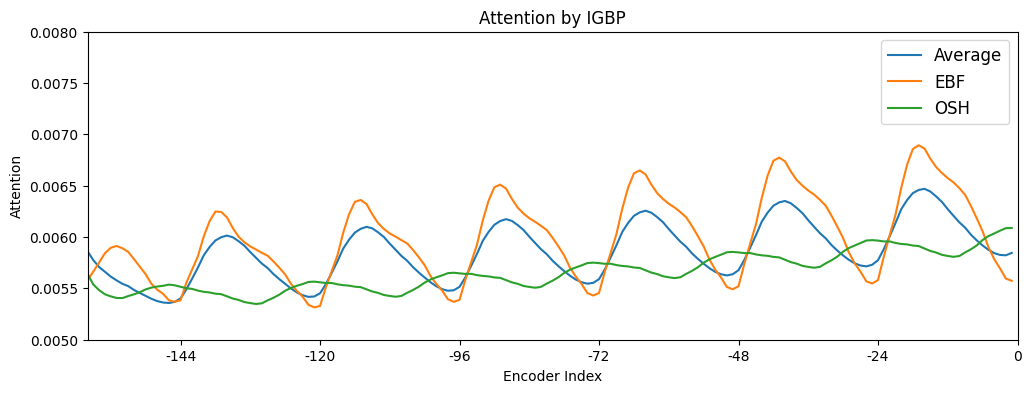

In [70]:
# Manually fill in top and bottom IGBP group (see other notebook "1_*" which has performance by igbp)
top_igbp = 'EBF'
bottom_igbp = 'OSH'
igbb_attn_dict_subset = {key: igbb_attn_dict[key] for key in ['Average', top_igbp, bottom_igbp] if key in igbb_attn_dict}

# Plot IGBP attn curves together
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(-ENCODER_LEN, 0)
for group, values in igbb_attn_dict_subset.items():
    ax.plot(range(-ENCODER_LEN, 0), values, label=group)
ax.legend(loc='upper right', prop={'size': 12})
ax.set_xlim([-ENCODER_LEN+8, 0])
ax.set_ylim([0.005, 0.008])
ax.set_xticks(np.arange(0, -ENCODER_LEN, -24))
ax.set_xticklabels([str(x) for x in np.arange(0, -ENCODER_LEN, -24)])
ax.set_ylabel('Attention')
ax.set_xlabel('Encoder Index')
plt.title('Attention by IGBP')
plt.show()

## Plot Actuals v Preds (with confidence bands) by site
Pick the site, the year, and month -> get the first week for that month plotted

In [25]:
# Get df to tie prediciton steps to dates
dec_ind_df_plot = pd.merge(dec_ind_df, split_df[['site_id', 'timestep_idx_global', 'year', 'month', 'day', 'hour']].drop_duplicates(), left_on=['site_id', 'time_idx_first_prediction'], right_on=['site_id', 'timestep_idx_global'])

In [39]:
# Choose params of plot
num_days_plot = 7
site = 'AU-Stp'
year = '2010'
month = '3'

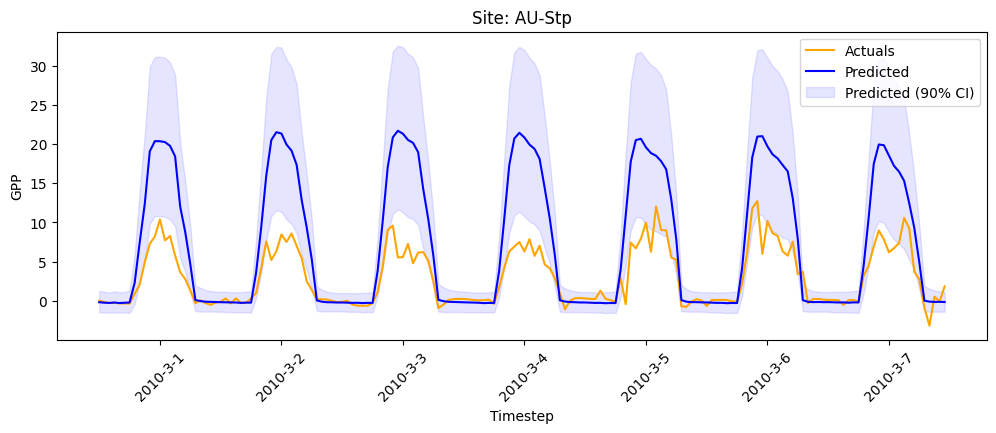

In [40]:
# Get inds, day values
site_year_month = dec_ind_df_plot.loc[(dec_ind_df_plot['site_id'] == site) & (dec_ind_df_plot['year'] == year) & (dec_ind_df_plot.month == month)].copy()
site_year_month_inds = site_year_month.index

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 4))
x_ticks = np.arange(24*num_days_plot)
plt.plot(x_ticks, actuals[site_year_month_inds][:24*num_days_plot], color='orange', label='Actuals')
plt.plot(x_ticks, preds_p50[site_year_month_inds][:24*num_days_plot], color='blue', label='Predicted')
plt.fill_between(x_ticks, preds_p10[site_year_month_inds][:24*num_days_plot],
                 preds_p90[site_year_month_inds][:24*num_days_plot], color='blue', alpha=0.1, label='Predicted (90% CI)')

# Add labels and legend
plt.title(f"Site: {site}")
plt.xlabel('Timestep')
plt.ylabel('GPP')
plt.legend(loc='upper right', prop={'size': 10})
ticks = range(12, 24*num_days_plot+12, 24)  # 1 tick per day
labels = [f"{year}-{month}-{day}" for day in site_year_month['day'].unique()[:num_days_plot]]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)
plt.show()